# IGFAE Lambda->pmunu Research

In [1]:
from numpy import *
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import uproot

In [3]:
file = uproot.open("GenLpmu2018MD_wMpi.root")  #This is our Lambda->pmunu signal simulation
file2 = uproot.open("GenLppi2018MD_wMpi.root") ##This is our Lambda->ppi background
tree = file["T"]
tree2= file2["T"]

In [4]:
pd_Signal=tree.arrays(library='pd')  
#here we create our dataframes, just with Lambda0_M and Lambda0_PT variables
pd_Background=tree2.arrays(library='pd')

/Users/dan-ioanbultoc/opt/anaconda3/lib/python3.9/site-packages/uproot/interpretation/library.py:798: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]


In [20]:
print(pd_Signal.keys())

Index(['Lambda0_ENDVERTEX_X', 'Lambda0_ENDVERTEX_Y', 'Lambda0_ENDVERTEX_Z',
       'Lambda0_ENDVERTEX_XERR', 'Lambda0_ENDVERTEX_YERR',
       'Lambda0_ENDVERTEX_ZERR', 'Lambda0_ENDVERTEX_CHI2',
       'Lambda0_ENDVERTEX_NDOF', 'Lambda0_ENDVERTEX_COV_', 'Lambda0_OWNPV_X',
       ...
       'Mppig', 'Mpmunu', 'APLA', 'MppiCorr', 'fit_pnuz', 'nu_fitchi2',
       'fit_pgz', 'g_fitchi2', 'corr_psc', 'corr_fitchi2'],
      dtype='object', length=541)


In [5]:
cutsSignal=(abs(pd_Signal['Lambda0_TRUEID'])==3122) & (abs(pd_Signal['p_TRUEID'])==2212) & (abs(pd_Signal['mu_TRUEID'])==13) & (abs(pd_Signal['mu_MC_MOTHER_ID'])==3122) & (abs(pd_Signal['p_MC_MOTHER_ID'])==3122) & (pd_Signal['Lambda0_TRUEENDVERTEX_Z']==pd_Signal['mu_TRUEORIGINVERTEX_Z'])

pd_SignalCuts=pd_Signal[cutsSignal]

In [6]:
cutsLppi=(abs(pd_Background['Lambda0_TRUEID'])==3122) & (abs(pd_Background['p_TRUEID'])==2212) & (abs(pd_Background['mu_TRUEID'])==211) & (abs(pd_Background['mu_MC_MOTHER_ID'])==3122) & (abs(pd_Background['p_MC_MOTHER_ID'])==3122) & (pd_Background['Lambda0_TRUEENDVERTEX_Z']==pd_Background['mu_TRUEORIGINVERTEX_Z'])
#pd_BackgroundCuts=pd_Background[(abs(pd_Background['Lambda0_TRUEID'])==3122) & (abs(pd_Background['p_TRUEID'])==2212) & (abs(pd_Background['mu_TRUEID'])==211) & (abs(pd_Background['mu_MC_MOTHER_ID'])==3122) & (abs(pd_Background['p_MC_MOTHER_ID'])==3122)]
pd_BackgroundCutsLppi=pd_Background[cutsLppi]


In [7]:
def vmod(v1):
    """ returns the modulo of the vector
    """
    mag = sqrt(vdot(v1,v1))
    return mag

In [8]:
def vtmod(v1):
    """ return the transverse module of the vector
    """
    mag = sqrt(v1[0]*v1[0]+v1[1]*v1[1])
    return mag

In [9]:
def vcross(v1,v2):
    """ cross products between 2 3D vectors
    """
    v30 =   v1[1]*v2[2]-v1[2]*v2[1]
    v31 =   v1[2]*v2[0]-v1[0]*v2[2]
    v32 =   v1[0]*v2[1]-v1[1]*v2[0]

    v3 = vector(v30,v31,v32)

    ##  print " cross ",v1,v2," = ",v3
    return v3;

In [10]:
class vector(list):
    
    def __init__(self,x,y,z):
        list.__init__(self,[x,y,z])


    def __add__(self,v2):        

        return vector(self[0]+v2[0],self[1]+v2[1],self[2]+v2[2])

    def __sub__(self,v2):

        return vector(self[0]-v2[0],self[1]-v2[1],self[2]-v2[2])

    
    def __mul__(self,n):

        #if isinstance(n,vector):
            #return sqrt(self[0]*n[0]+self[1]*n[1]+self[2]*n[2])

    
        return vector(n*self[0],n*self[1],n*self[2])

    
    __rmul__=__mul__
    
    def __div__(self,n):
        a = 1./n
        return self*a

    __rdiv__=__div__
    
    def __neg__(self):

        return self*(-1)

In [11]:
def vunit(v):
    """  makes unitary this vector
    """
    udir = v
    mod = vmod(v)
    if (mod != 0.): udir = v/vmod(v)
    return udir

In [12]:
def IM2(p1,p2,m1,m2):
    """returns the Invariant Mass of two tracks with p1 and p2, for masses m1 m2"""
    t1=-1*vdot(p1,p2)
    pm1=vmod(p1)
    pm2=vmod(p2)
    t2=sqrt((m1*m1+pm1*pm1)*(m2*m2+pm2*pm2))
    masa2=m1*m1+m2*m2+2*(t1+t2)
    return masa2

In [13]:
def do(pd,i):
    pmu = vector(pd['mu_PX'][i], pd['mu_PY'][i], pd['mu_PZ'][i])
    pp = vector(pd['p_PX'][i], pd['p_PY'][i], pd['p_PZ'][i])
    Mpmu = sqrt(IM2(pmu,pp, 105.6583715, 938.27208816)) ## IM2 = invariant mass squared                                                                                                                

    PV = vector(pd['Lambda0_OWNPV_X'][i],pd['Lambda0_OWNPV_Y'][i],pd['Lambda0_OWNPV_Z'][i])
    SV = vector(pd['Lambda0_ENDVERTEX_X'][i],pd['Lambda0_ENDVERTEX_Y'][i],pd['Lambda0_ENDVERTEX_Z'][i])

    flight = vunit(SV-PV)
    ppmu = pp + pmu
    xu = vcross(vector(0,1,0),flight)
    yu = vcross(flight,xu)
    ppmux_prime = vdot(ppmu, xu)
    ppmuy_prime = vdot(ppmu, yu)
    ppmuz_prime = vdot(ppmu, flight)

    pm_prime = vector(ppmux_prime, ppmuy_prime, ppmuz_prime)

    return [vtmod(pm_prime),pd['Lambda0_M'][i]]

In [14]:
do(pd_SignalCuts,0)[0]


36.196367048881584

# TASKS

1. Investigate how to add a new variable to a panda dataframe.

2. Add for each event (i) a new variable called 'Missing_pT'=do(pd_SignalCuts,i)[0]

3. Reproduce this plot including the 3 channels (Lpmunu, Lppi, eDIF)


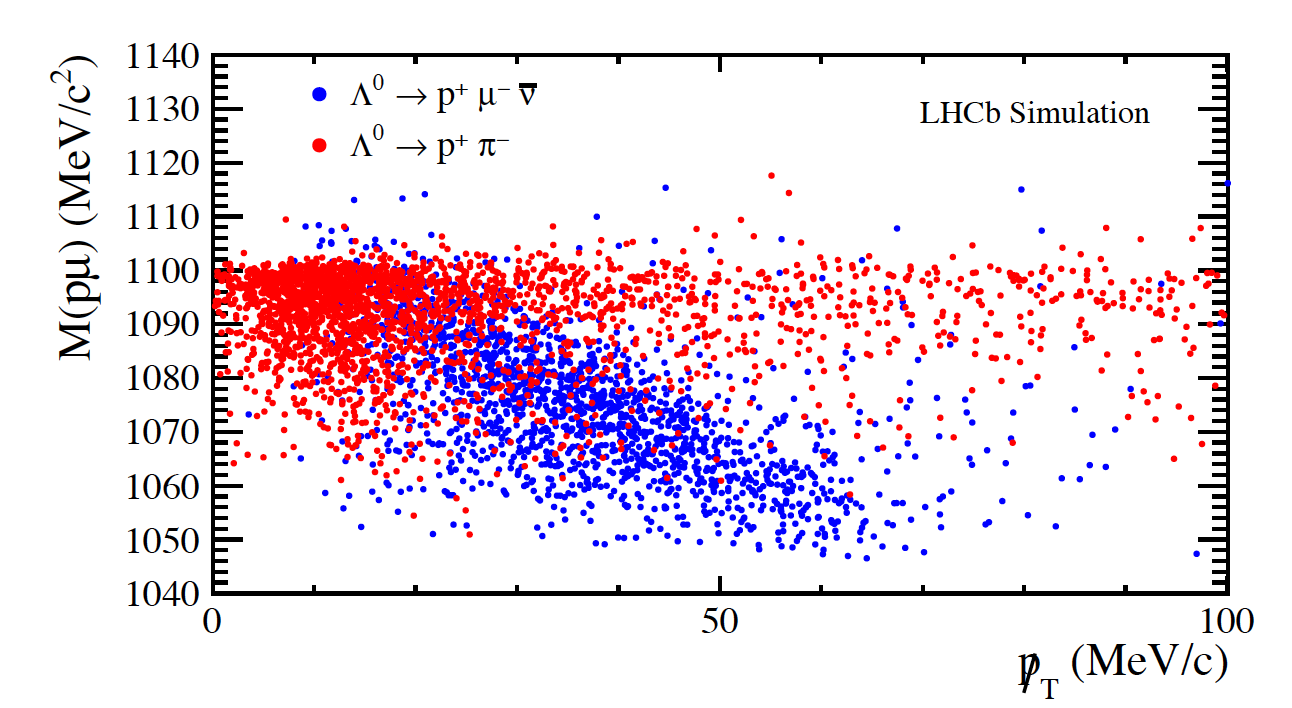

In [15]:
for i in pd_SignalCuts.index:
    #print(do(pd_SignalCuts,i)[0])
    Missing_pT=do(pd_SignalCuts,i)[0]

In [16]:
#Missing_pT=do(pd_SignalCuts,i)[0]
pd_SignalCuts.insert(0,'Missing_pT', Missing_pT)

In [17]:
print(pd_SignalCuts)

        Missing_pT  Lambda0_ENDVERTEX_X  Lambda0_ENDVERTEX_Y  \
0        25.485811              -0.4647             8.858700   
2        25.485811               6.5536            16.523600   
3        25.485811              -9.3852            -8.670600   
4        25.485811               8.1912             4.008600   
5        25.485811               2.8095            12.291000   
...            ...                  ...                  ...   
102070   25.485811               8.6788           -22.790001   
102071   25.485811               4.7183             4.104300   
102072   25.485811               3.5559            11.970800   
102073   25.485811              13.4761           -19.659700   
102074   25.485811              -9.9923            -5.691400   

        Lambda0_ENDVERTEX_Z  Lambda0_ENDVERTEX_XERR  Lambda0_ENDVERTEX_YERR  \
0                517.804504                  0.0197                  0.0505   
2                416.891815                  0.0890                  0.24